In [289]:
import numpy as np
import pandas as pd
import xgboost as xgb

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.model_selection import train_test_split

In [290]:
cal_housing = fetch_california_housing()

In [291]:
print cal_housing.feature_names, cal_housing.data.shape

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] (20640, 8)


In [292]:
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.4,
                                                    random_state=123)

In [293]:
feature_names = ['MedInc', 'AveOccup', 'HouseAge'] 
feature_ids = [cal_housing.feature_names.index(f) for f in feature_names]

In [294]:
dtrain = xgb.DMatrix(X_train[:, feature_ids].reshape(len(X_train), len(feature_ids)), label = y_train)
dtest =  xgb.DMatrix(X_test[:, feature_ids].reshape(len(X_test), len(feature_ids)), label = y_test)

In [295]:
#feature_monotones = [0] * (len(feature_names))
feature_monotones = [1, -1, 1]

params = {'max_depth': 2,
          'eta': 0.1, 
          
          'silent': 1,
          'nthread': 2,
          'seed': 0,
          'eval_metric': 'rmse', 
          
          'monotone_constraints': '(' + ','.join([str(m) for m in feature_monotones]) + ')'
         }

bst_cv = xgb.cv(params, dtrain, 500, nfold = 5, early_stopping_rounds=10)

In [296]:
evallist  = [(dtrain, 'train'), (dtest, 'eval')]

evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round = bst_cv.shape[0], evals_result = evals_result, evals = evallist,  verbose_eval = False)

In [297]:
print 'Number of boosting rounds %d,\
       Training RMSE: %.4f, \
       Testing RMSE: %.4f' % \
       (len(evals_result['train']['rmse']),
        evals_result['train']['rmse'][-1], 
        evals_result['eval']['rmse'][-1])

Number of boosting rounds 130,       Training RMSE: 0.6955,        Testing RMSE: 0.6926


In [298]:
def partial_dependency(bst, X, y, feature_ids = [], f_id = -1):
    
    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()
    
    grid = np.linspace(np.percentile(X_temp[:, f_id], 0.1), 
                       np.percentile(X_temp[:, f_id], 99.5), 
                       50)
    y_pred = np.zeros(len(grid))
    
    if len(feature_ids) == 0 or f_id == -1:
        print 'Input error!'
        return
    else:
        for i, val in enumerate(grid):
            
            X_temp[:, f_id] = val
            data = xgb.DMatrix( X_temp[:, feature_ids].reshape( (len(X_temp), len(feature_ids)) ) )

            y_pred[i] = np.average(bst.predict(data, ntree_limit = bst.best_ntree_limit))
    
    return grid, y_pred

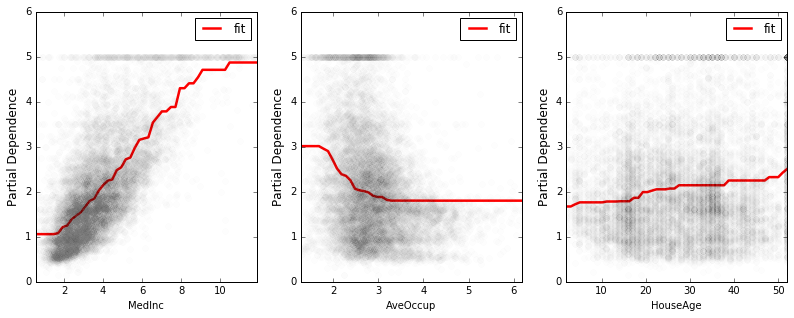

In [299]:
fig, ax = plt.subplots(1, len(feature_names))
fig.set_size_inches(len(feature_names) * 4, 5)
plt.subplots_adjust(left = 0.07, right = 0.94, bottom = 0.15, top = 0.9)

for i, f in enumerate(feature_names):

    grid, y_pred = partial_dependency(bst, 
                                      X_train, 
                                      y_train, 
                                      feature_ids = feature_ids,
                                      f_id = cal_housing.feature_names.index(f)
                                     )
    
    if i ==0 and len(feature_names) == 1:
        axis = ax
    else:
        axis = ax[i]
        
    axis.plot(grid, y_pred, '-', color = 'red', linewidth = 2.5, label='fit')
    axis.plot(X_train[:, cal_housing.feature_names.index(f)], y_train, 'o', color = 'grey', alpha = 0.01)

    axis.set_xlim(min(grid), max(grid))
    axis.set_xlabel(f, fontsize = 10)
    axis.set_ylabel('Partial Dependence', fontsize = 12)
    
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, loc = 'best', fontsize = 12)
    plt.savefig('w_constraint_three_feature.png')